# CARV-ST-MAE Figure Replication

This notebook will replicate the figures and exploratory analysis from our presentation, milestone, final report, and proposal documents.

## Downloading Dependencies

### Loading in the python packages from [the repository's `code/requirements.txt`](https://github.com/rechhabra/carv-st-mae/blob/main/code/requirements.txt)

In [1]:
#installing requirements as instructed on repo README.md
#creating code folder and its contents
%mkdir code

#copied from code/requirements.txt on the repo
requirements = """
### Non-version-dependent requirements ###
#opencv3
simplejson
matplotlib
iopath
common
fvcore
av
scikit-video
scipy
PyTube
pandas
matplotlib
wget
numpy
glob2
#----------------------------------------#


#----------------------------------------#
###   Version-dependent requirements   ###
timm==0.4.5 # 0.3.2 does not work in Colab
#----------------------------------------#
"""

with open("code/requirements.txt", "w") as req:
  req.write(requirements)

%pip install -r code/requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.4/137.4 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 2.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.2/31.2 MB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 21.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.2/57.2 kB 3.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 287.4/287.4 kB 18.5 MB/s eta 0:00:00
  Created wheel for iopath: filename=iopath-0.1.10-py3-none-any.whl size=31547 sha256=43a1f070ea703d73512bea9c7df86f8038d3d0de3fb23ac224c8beea4bcd5ce9
  Stored in directory: /

### Following the [`imported_repo` folder's README](https://github.com/rechhabra/carv-st-mae/tree/main/code/imported_repos) instructions

In [2]:
#creating required code/imported_repo folder as in repo
%mkdir code/imported_repos

#adding used repositories as instructed from code/imported_repos/ README
!git clone https://github.com/haooooooqi/visualization.git
!mv visualization code/imported_repos/mae #edited to move into appropriate folder as it is in the repo
!git clone https://github.com/facebookresearch/SlowFast.git
!mv SlowFast code/imported_repos/slowfast #edited to move into appropriate folder as it is in the repo


import sys
sys.path.append('./code/imported_repos/mae')
sys.path.append('./code/imported_repos/')
sys.path.append('./code/imported_repos/slowfast')
sys.path.append('..')
sys.path.append('./')

Cloning into 'visualization'...
remote: Enumerating objects: 193, done.
remote: Counting objects: 100% (149/149), done.
remote: Compressing objects: 100% (83/83), done.
remote: Total 193 (delta 78), reused 127 (delta 66), pack-reused 44
Receiving objects: 100% (193/193), 21.49 MiB | 21.37 MiB/s, done.
Resolving deltas: 100% (80/80), done.
Cloning into 'SlowFast'...
remote: Enumerating objects: 2013, done.
remote: Total 2013 (delta 0), reused 0 (delta 0), pack-reused 2013
Receiving objects: 100% (2013/2013), 31.27 MiB | 20.28 MiB/s, done.
Resolving deltas: 100% (1412/1412), done.


In [3]:
#importing the libraries listed in code/requirements.txt file

import skvideo.io
import scipy

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from multiprocessing import Pool

import tqdm
from tqdm import tqdm

import tarfile
import pytube

import sys
import os
import os.path as osp

import requests
import argparse
import urllib.request

import torch

from PIL import Image

import glob

In [4]:
#importing models_mae -- model from imported repo
import models_mae

### Following the [data folder's README instructions](https://github.com/rechhabra/carv-st-mae/tree/main/data)

Load a small fraction (up to 100 videos) of the Kinetics 400 dataset using code from https://github.com/chi0tzp/KineticX-Downloader

In [5]:
# load videos
# From https://github.com/chi0tzp/KineticX-Downloader

global video_output_dir, error_file

#edit from repo: defining the global variable
#creating data folder in co lab
%mkdir data

errors = 0

def download_video(youtube_id):
    """Download video from YouTube using PyTube.
    Args:
        youtube_id (str): Youtube id (https://www.youtube.com/watch?v=<youtube_id>)
    """
    global error_file, errors
    try:
        youtube = pytube.YouTube('https://www.youtube.com/watch?v=' + youtube_id)
        video = youtube.streams.first()
        video_filename = osp.join(video_output_dir, youtube_id + '.' + video.subtype)
        if (not osp.isfile(video_filename)) or (os.stat(video_filename).st_size == 0):
            try:
                video.download(output_path=video_output_dir, filename=youtube_id)
            except:
                with open(error_file, "a") as f:
                    f.write("{}\n".format(youtube_id))
                    errors += 1
    except:
        with open(error_file, "a") as f:
            f.write("{}\n".format(youtube_id))
            errors += 1


def load_K400_videos():
    parser = argparse.ArgumentParser("Kinetics dataset downloader")
    parser.add_argument('-v', '--version', type=str, default='400', choices=('400', '600', '700'),
                        help="choose dataset version ('400', '600', '700')")
    parser.add_argument('-s', '--subset', type=str, default='val', choices=('train', 'test', 'validate', 'all'),
                        help="choose dataset subset ('train', 'test', 'validate', or 'all')")
    parser.add_argument('-w', '--workers', type=int, default=None, help="Set number of multiprocessing workers")
    args = parser.parse_args(["-s", "test"]) #args here

    print("#.Download Kinetics{} dataset...".format(args.version))

    # Define dataset root directory name
    # NOTE: edited path to work in colab
    root_dir = 'data/Kinetics{}'.format(args.version)

    # Create directory for downloading URLs and annotation files
    anno_dir = osp.join(root_dir, "annotations")
    if not osp.exists(anno_dir):
        os.makedirs(anno_dir, exist_ok=True)

    print("#.Download URLs and annotations tar.gz file for Kinetics{}...".format(args.version))
    anno_root_url = "https://storage.googleapis.com/deepmind-media/Datasets/kinetics"
    anno_tar_file = osp.join(anno_dir, "kinetics{}.tar.gz".format(args.version))
    try:
        urllib.request.urlretrieve(url="{}{}.tar.gz".format(anno_root_url, args.version),
                                   filename=anno_tar_file)
    except:
        raise ConnectionError("Could not download URLs and annotations file: {}".format(anno_tar_file))

    print("#.Extract URLs and annotations tar.gz file for Kinetics{}...".format(args.version))
    tf = tarfile.open(anno_tar_file)
    tf.extractall(path=anno_dir, members=None)
    anno_dir = osp.join(anno_dir, 'kinetics{}'.format(args.version))

    # Create directory for downloading videos
    video_dir = osp.join(root_dir, "videos")
    if not osp.exists(video_dir):
        os.makedirs(video_dir)

    # Get dataset subset(s) for downloading
    subsets = (args.subset, )
    if args.subset == 'all':
        subsets = ('train', 'test', 'validate')

    # Download dataset subset
    for subset in subsets:
        print("#.Process subset: {}".format(subset))
        global video_output_dir, error_file

        # Create dir for dataset subset
        video_output_dir = osp.join(video_dir, subset)
        if not osp.exists(video_output_dir):
            os.makedirs(video_output_dir)

        # Define error log file
        error_file = 'Kinetics{}_{}_errors.log'.format(args.version, subset)
        if osp.exists(error_file):
            os.remove(error_file)

        # Parse URLs csv file and get a list of YouTube IDs to download
        print("  \\__Parse URLs csv file...")
        youtube_ids = pd.read_csv(osp.join(anno_dir, '{}.csv'.format(subset))).youtube_id.tolist()

        # only take subset
        youtube_ids = youtube_ids[:100]

        # Download YouTube videos for given IDs
        print("  \\__Download videos...")
        pool = Pool(args.workers)
        for _ in tqdm(pool.imap_unordered(download_video, youtube_ids), total=len(youtube_ids)):
            pass
        pool.close()

load_K400_videos()

#.Download Kinetics400 dataset...
#.Download URLs and annotations tar.gz file for Kinetics400...
#.Extract URLs and annotations tar.gz file for Kinetics400...
#.Process subset: test
  \__Parse URLs csv file...
  \__Download videos...


100%|██████████| 100/100 [01:42<00:00,  1.02s/it]


In [6]:
#NOTE: added method from repo: converting videos to be mp4
def convert_to_mp4():
  for file in glob.glob("/content/data/Kinetics400/videos/test/*"):
    _, ext = os.path.splitext(file)
    if len(ext) == 0:
      os.rename(file, file + ".mp4")

convert_to_mp4()

## Processing Video Methods

Making the methods to process the video to a given dimension. Class also has helper methods to display the videos in an easy-to-view manner.

In [25]:
#class methods inspired from imported ST-MAE repository
class VideoProcessor:
  num_frames: int
  dim_width:  int
  dim_height: int
  mean: float = 0.45  #from Kinetic400 paper
  std: float  = 0.225 #from Kinetic400 paper

  def __init__(self, num_frames=16, dim_width=224, dim_height=224) -> None:
    self.num_frames = num_frames
    self.dim_width  = dim_width
    self.dim_height = dim_height

  def resize_video(self, video) -> np.ndarray:
    new_frames = self.num_frames / video.shape[0]
    new_width  = self.dim_width / video.shape[1]
    new_height = self.dim_height / video.shape[2]
    new_video = scipy.ndimage.zoom(
        video, 
        (new_frames, new_width, new_height, 1), 
        order=1
    )

    return new_video

  def normalize_frames(self, frames) -> np.ndarray:
    frames = np.float32(frames) / 255
    frames = (frames - self.mean)/self.std

    return frames

  def process_video(self, filepath) -> torch.Tensor:
    frames = skvideo.io.vread(filepath)
    frames = self.resize_video(frames)
    frames = self.normalize_frames(frames)
    frames = torch.tensor(frames).permute(3, 0, 1, 2)
    #frames = frames.uint8

    return frames

  def plot_input(self, tensor) -> None:
    tensor = tensor.float()
    f, axs = plt.subplots(nrows=tensor.shape[0], ncols=tensor.shape[1], figsize=(20, 6))

    tensor = tensor * torch.tensor((self.std, self.std, self.std)).view(3, 1, 1)
    tensor = tensor + torch.tensor((self.mean, self.mean, self.mean)).view(3, 1, 1)

    tensor = torch.clip(tensor * 255, 0, 255).int()

    for i in range(tensor.shape[0]):
        for j in range(tensor.shape[1]):
            axs[i][j].axis("off")
            axs[i][j].imshow(tensor[i][j].permute(1, 2, 0))
    
    plt.show()

  def plot_video(self, video, title = "") -> None:
    #4 elements with diff dimensions: 
    # [frames, height, width, colors=3]
    video = video.permute(1,2,3,0)
    plt.figure(figsize = [24, 24])
    
    #plot frames
    num_frames = video.shape[0]
    for frame_index in range(num_frames):
      plt.subplot(num_frames//4 + 1, 4, frame_index+1)
      #unnormalizing frame
      plt.imshow(torch.clip((video[frame_index]*self.std + self.mean) * 255, 0, 255).int())
      plt.axis('off')

    plt.title(title)
    plt.show()

## Loading Up MAE Model

In [8]:
from mae.models_mae import mae_vit_large_patch16
model = mae_vit_large_patch16(decoder_embed_dim=512, decoder_depth=4, mask_type="st", t_patch_size=2)

img_size (224, 224) patch_size (16, 16) frames 16 t_patch_size 2
==== num_patches 1568
model initialized


We also have to load in the model

In [9]:
#creating models folder as in the repo
%mkdir models
%cd models
!wget 'https://dl.fbaipublicfiles.com/video-mae-100x4-joint.pth' -O checkpoint.pth
%cd ..

/content/models
--2023-04-17 21:59:38--  https://dl.fbaipublicfiles.com/video-mae-100x4-joint.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 108.157.162.108, 108.157.162.35, 108.157.162.120, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|108.157.162.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3823763371 (3.6G) [binary/octet-stream]
Saving to: ‘checkpoint.pth’

checkpoint.pth      100%[===================>]   3.56G   127MB/s    in 30s     

2023-04-17 22:00:08 (122 MB/s) - ‘checkpoint.pth’ saved [3823763371/3823763371]

/content


In [10]:
checkpoint = torch.load("models/checkpoint.pth", map_location='cpu')
msg = model.load_state_dict(checkpoint['model'], strict=False)
print(msg)

<All keys matched successfully>


## Figure 1: ST-MAE Video Example

We will use the video `BQwNszotto` from the Kinetic400 as an example.

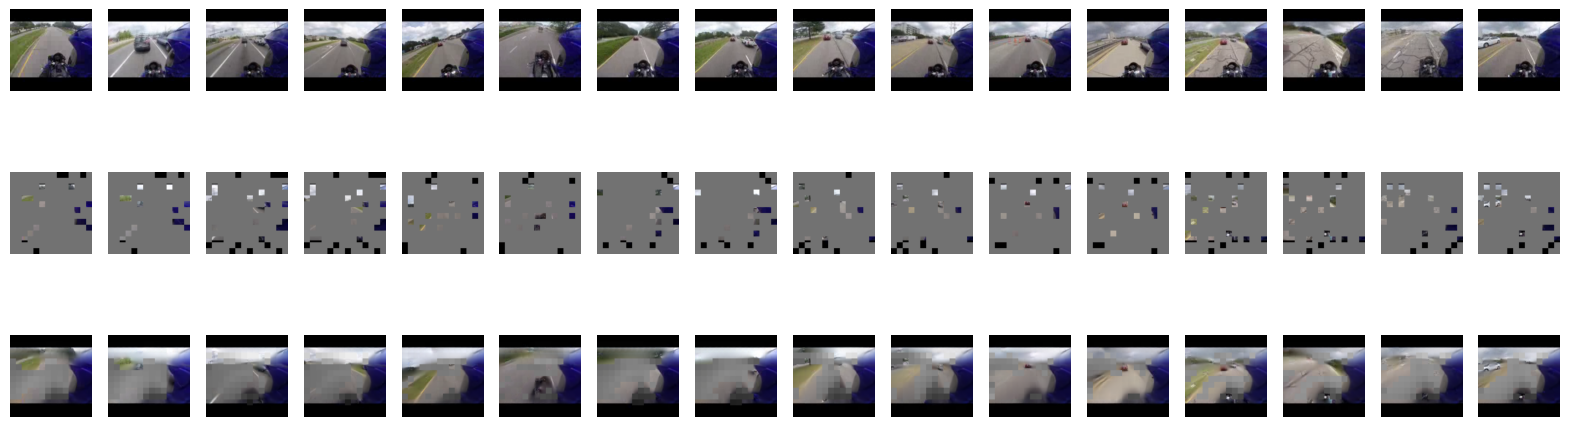

In [11]:
video_processor = VideoProcessor()
vid = video_processor.process_video("data/Kinetics400/videos/test/-BQwNszotto.mp4")

loss, pred, mask, vis = model(vid.unsqueeze(0), 1, mask_ratio=0.9, visualize=True)
video_processor.plot_input(vis[0].permute(0, 2, 1, 3, 4))

## Figure 2: Viewing The Most and Least Important Chunks

To analyze this, we will use the main `CARVSTMAE` class and obtain the most important chunks for the heatmap

In [27]:
sys.path.append('./imported_repos/mae')
sys.path.append('./imported_repos/')
sys.path.append('..')

from models_mae import mae_vit_large_patch16

class CARVSTMAE:
    num_chunk_sampling: int
    mask_ratio: int
    chunk_dim: np.ndarray
    video_processor: VideoProcessor = VideoProcessor()
    model: mae_vit_large_patch16
    top_chunks: int #we will use the top X chunks to reconstruct the video

    def __init__(self,
                 num_chunk_sampling: int = 500,
                 mask_ratio: int = 0.95,
                 chunk_dim: np.ndarray=[2, 16, 16],
                 top_chunks: int = 150
    ):
        self.num_chunk_sampling = num_chunk_sampling
        self.mask_ratio = mask_ratio
        self.chunk_dim = chunk_dim
        self.top_chunks = top_chunks
        self.model = mae_vit_large_patch16(decoder_embed_dim=512, decoder_depth=4, mask_type="st", t_patch_size=2)

    def compress_video(self, filepath: str):
        video = self.video_processor.process_video(filepath)
        chunks = self.randomly_sample_chunks(video)
        #TODO: compress video

    def generate_chunks_mse(self, video: torch.Tensor) -> np.ndarray:
        """
        Generates the MSE for each chunk in the video using random mask sampling
        param video: the video to be compressed
        return: the MSE for each chunk in the video
        """
        vid_channels, vid_frames, vid_width, vid_height = video.shape

        try:
            mask_frames, mask_width, mask_height = vid_frames/self.chunk_dim[0], vid_width/self.chunk_dim[1], vid_height/self.chunk_dim[2]
            assert mask_frames.is_integer() and mask_width.is_integer() and mask_height.is_integer()
            mask_frames, mask_width, mask_height = int(mask_frames), int(mask_width), int(mask_height)
        except AssertionError as e:
            print(f"Error: Selected chunk dimensions {self.chunk_dim} do not divide evenly into video dimensions {video.shape}")

        mse_sum: torch.Tensor = torch.tensor(np.zeros((mask_frames, mask_width, mask_height)))
        mask_count: np.ndarray = np.zeros((mask_frames, mask_width, mask_height))

        for i in tqdm(range(self.num_chunk_sampling)):
            loss, pred, mask, vis = self.model(video.unsqueeze(0), 1, mask_ratio=self.mask_ratio)
            fragment = 1 - (mask.reshape(mask_frames, mask_width, mask_height))
            mask_count = np.add(mask_count, fragment)
            mse_sum = np.add(mse_sum, fragment * (float)(loss))

        #ensure all mask_count values are not 0
        mask_count = np.where(mask_count == 0, 1, mask_count)
        mse_sum = np.divide(mse_sum, mask_count)

        return mse_sum

    def plot_chunks_mse_heat_map(self, mse_sum, video):
        mse_sum_df = pd.Series(mse_sum.flatten())

        #filter out chunks that were not selected -- values that are 0
        mse_sum_df = mse_sum_df[mse_sum_df > 0]

        best_chunks = np.argsort(mse_sum_df.ravel())[:self.top_chunks]
        worst_chunks= np.argsort(mse_sum_df.ravel())[-self.top_chunks:]

        best_fragments = np.zeros(mse_sum.shape)

        for mse in best_chunks:
            best_fragments[np.unravel_index((int)(mse), mse_sum.shape)] = 1

        worst_fragments = np.zeros(mse_sum.shape)
        for mse in worst_chunks:
            worst_fragments[np.unravel_index((int)(mse), mse_sum.shape)] = 1

        best_fragments = scipy.ndimage.zoom(best_fragments, (self.chunk_dim[0], self.chunk_dim[1], self.chunk_dim[2]), mode="nearest", order=1)
        worst_fragments = scipy.ndimage.zoom(worst_fragments, (self.chunk_dim[0], self.chunk_dim[1], self.chunk_dim[2]), mode="nearest", order=1)

        heat_video = 0.25 + video/2
        heat_video[0] = np.add(heat_video[0], 3*worst_fragments)
        heat_video[1] = np.add(heat_video[1], 3*best_fragments)

        self.video_processor.plot_video(heat_video, title = f"Most important (green) and least {self.top_chunks} chunks (red)\nusing {self.num_chunk_sampling} samples with a {self.mask_ratio} mask ratio")    

In [1]:
carv = CARVSTMAE(num_chunk_sampling=10)

chunks_mse = carv.generate_chunks_mse(vid)

NameError: ignored

In [26]:
#plotting the heat map

carv.plot_chunks_mse_heat_map(chunks_mse, vid)

TypeError: ignored

In [ ]:
data.to_csv("mse_" + str(num_sample) +"_"+ str((int)(1000 * mask_ratio)) + "_-BQwNszotto.csv")

In [ ]:
data.describe()

In [ ]:
data = pd.read_csv("/content/mse_500_993_-BQwNszotto.csv")
data = data[data > 0]
data.describe()